
# Homework #2 – Titanic 생존자 예측 (PyTorch + W&B)



## 선행 설정. 환경 설정 & W&B 설정
WANDB에 연동하고 기본적인 설정을 수행한다.  
외장 그래픽이 있는 노트북이라 CUDA로도 테스트를 수행한 흔적이 있음.(RTX 5060)  

In [2]:

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pandas scikit-learn wandb

import os
import math
import time
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Weights & Biases (실험 기록용)
import wandb

# W&B 로그인

# 프로젝트/실험명
WANDB_PROJECT = "hw2-titanic"
WANDB_ENTITY = None 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("PyTorch device:", DEVICE)


Looking in indexes: https://download.pytorch.org/whl/cpu


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PYS\_netrc


PyTorch device: cpu



## 2. 데이터 전처리 로딩

- 이미 제공된 `titanic_dataset.py`를 사용한다
- 실행 결과로 `train_dataset`, `validation_dataset`, `test_dataset`을 받음
- 입력 차원이 dim =  10임을 체크.


In [3]:

# titanic_dataset.py는 .ipynb와 같은 폴더에 있다고 가정하고 
import importlib.util, sys, os

TITANIC_DS_PATH = os.path.join(os.getcwd(), "titanic_dataset.py")
if not os.path.exists(TITANIC_DS_PATH):
    if os.path.exists(alt_path):
        TITANIC_DS_PATH = alt_path

spec = importlib.util.spec_from_file_location("titanic_dataset", TITANIC_DS_PATH)
titanic_dataset = importlib.util.module_from_spec(spec)
sys.modules["titanic_dataset"] = titanic_dataset
spec.loader.exec_module(titanic_dataset)

train_dataset, valid_dataset, test_dataset = titanic_dataset.get_preprocessed_dataset()

print("Train size:", len(train_dataset))
print("Valid size:", len(valid_dataset))
print("Test size:", len(test_dataset))

# 데이터 로더 (기본 배치사이즈 32)
default_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=default_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=len(test_dataset),  shuffle=False)

# 한 배치를 꺼내서 feature shape 확인
ex_batch = next(iter(valid_loader))
in_dim = ex_batch["input"].shape[1]
num_classes = 2  # 생존/사망
print("Detected input_dim =", in_dim, "// num_classes =", num_classes)


C:\Users\PYS\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\PYS\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0750         2      0   
8       1.0       3    0  27.0      0      2  11.1333         2      3   
9       1.0       2    0  14.0      1      0  30.0708         0      3   

   family_num  alone  
0           1    0.


## 요구사항 1

- 01_code/_08_learning_and_optimization/c_my_model_training_with_argparse_wandb.py 코드를 그대로 활용하되 titanic 데이터에 맞게 수정하여 코딩
- 또, 실행 후 그래프 얻어내기 및 Wandb URL 얻어내기.

In [ ]:
import os
import sys

from datetime import datetime
from dataclasses import dataclass

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import wandb
import argparse
import numpy as np

# 활성화 함수 관련 패러미터 처리

def get_activation(name: str):
    name = (name or "sigmoid").lower()
    if name == "sigmoid":
        return nn.Sigmoid()    
    if name == "relu":
        return nn.ReLU()
    if name == "elu":
        return nn.ELU()
    if name in ("leakyrelu", "leaky_relu", "lrelu"):
        return nn.LeakyReLU()
    raise ValueError(f"Unsupported activation: {name}")

def get_titanic_dataloaders(batch_size: int):
    """
    titanic_dataset.py에서 제공하는 get_preprocessed_dataset()을 이용.
    - train/valid/test 세 개 데이터셋을 반환받고
    - 그중 train하고 valid만 데이터로더로 묶어서 반환.
    """
    import importlib.util
    TITANIC_DS_PATHS = [
        os.path.join(os.getcwd(), "titanic_dataset.py")
        ]
    ds_path = None
    for p in TITANIC_DS_PATHS:
        if os.path.exists(p):
            ds_path = p
            break
    
    # 오류 발생으로 인한 동적 및 강제 import
    spec = importlib.util.spec_from_file_location("titanic_dataset", ds_path)
    titanic_dataset = importlib.util.module_from_spec(spec)
    sys.modules["titanic_dataset"] = titanic_dataset
    spec.loader.exec_module(titanic_dataset)

    # 전처리된 데이터셋 가져오기
    train_ds, valid_ds, test_ds = titanic_dataset.get_preprocessed_dataset()

    # 파이토치 데이터로더
    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=len(valid_ds), shuffle=False)

    # 검증 데이터 배치 하나에서 input_dim(그러니까 특징 개수=10)을 추론
    ex = next(iter(valid_loader))
    input_dim = ex["input"].shape[1]

    return train_loader, valid_loader, input_dim

# ---------- Model ----------

# 원본 캘리포니아 하우스는 회귀라 분류로 수정.
# 또한 출력 차원도 1에서 2(사망/생존)로 수정.
# 처리 용이를 위해 입출력도 딕셔너리로 받아오도록....

class MyModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int, activation: str = "relu", dropout: float = 0.1):
        super().__init__()
        act = get_activation(activation) # ReLU/Sigmoid/ELU/LeakyReLU 중 인자로 받아오는...
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            act,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            act,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes), # 출력 2
        )

    def forward(self, x):
        return self.net(x)

# 학습 용이화를 위한 파라미터 구조화

@dataclass
class TrainConfig:
    input_dim: int
    num_classes: int = 2
    hidden_dim: int = 64
    activation: str = "relu"
    dropout: float = 0.1
    batch_size: int = 32
    max_epochs: int = 30
    lr: float = 1e-3
    weight_decay: float = 0.0
    project: str = "hw2-titanic"
    entity: str | None = None
    run_name: str | None = None

# 학습 루프
# 한 에포크 단위로 학습 -> 검증 -> wandb 로깅

def training_loop(model, optimizer, train_loader, valid_loader, max_epochs=30, device="cpu"):
    # 손실 함수: 분류용으로 변경
    criterion = nn.CrossEntropyLoss() # 분류니까 MSELoss -> CrossEntropyLoss
    model.to(device)
    # 가장 좋은 검증 손실 기록용
    best_state = None
    # 검증 손실 초기화
    best_valid_loss = float("inf")
    global_step = 0
    # 에포크 단위 학습
    for epoch in range(1, max_epochs + 1):
        model.train() # 학습 모드
        train_losses = [] # 에포크 내 배치 손실 기록용
        for batch in train_loader: # 배치 단위 학습
            x = batch["input"].to(device) # 입력
            y = batch["target"].to(device) # 타겟
            # 순전파
            logits = model(x)
            # 손실 계산
            loss = criterion(logits, y)
            # 역전파 및 최적화
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            # 배치 손실 기록
            train_losses.append(loss.item())
            global_step += 1

        # 검증. 전체 검증 배치를 한 번에 평가하도록
        # 검증은 기울기 계산 안 함
        model.eval()
        # 검증 손실과 정확도 계산
        with torch.no_grad():
            # 검증 배치 하나 가져오기
            vbatch = next(iter(valid_loader))
            vx = vbatch["input"].to(device)
            vy = vbatch["target"].to(device)
            vlogits = model(vx)
            vloss = criterion(vlogits, vy).item() # 검증 손실
            preds = vlogits.argmax(dim = 1) # 예측 클래스
            vacc = (preds == vy).float().mean().item() # 정확도 계산
        # W&B 로깅
        mean_train_loss = float(np.mean(train_losses)) if train_losses else float('nan')
        wandb.log({
            "epoch": epoch,
            "Training loss": mean_train_loss,
            "Validation loss": vloss,
            "Validation acc": vacc,
        }, step=global_step)

        # validation loss가 가장 좋았던 모델 상태 저장
        if vloss < best_valid_loss:
            best_valid_loss = vloss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 10 == 0:
            print(f"[{epoch:03d}] train_loss={mean_train_loss:.4f}  valid_loss={vloss:.4f}  valid_acc={vacc:.4f}")
    # 가장 좋은 상태로 모델 복원
    if best_state is not None:
        model.load_state_dict(best_state)

    return model

# ---------- Main ----------

def main(args):
    # 현재 시각 문자열
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # wandb에 기록할 설정값 딕셔너리다.
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [args.hidden, args.hidden],
        'activation': args.activation,
    }
    # W&B 초기화
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="hw2-titanic",
        notes="Titanic classification (PyTorch MLP)",
        tags=["titanic", "classification", args.activation, f"bs{args.batch_size}"],
        name=current_time_str,
        config=config
    )

    # Data
    train_loader, valid_loader, input_dim = get_titanic_dataloaders(args.batch_size)

    model = MyModel(
        input_dim=input_dim,
        hidden_dim=args.hidden,
        num_classes=2,
        activation=args.activation,
        dropout=0.1,
    )
    # 옵티마이저 세팅
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # 학습 실행
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device, "/ input_dim:", input_dim, "/ activation:", args.activation, "/ batch:", args.batch_size)
    # 학습 루프 호출
    training_loop(model, optimizer, train_loader, valid_loader, max_epochs=args.epochs, device=device)

    wandb.finish()

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=False, help="Enable W&B logging")
    parser.add_argument("-b", "--batch_size", type=int, default=32, help="Batch size (default: 32)")
    parser.add_argument("-e", "--epochs", type=int, default=30, help="Number of training epochs (default: 30)")
    parser.add_argument("-a", "--activation", type=str, default="relu", # 활성화 함수 인자 추가
                        choices=["relu", "sigmoid", "elu", "leaky_relu"],
                        help="Activation function (default: relu)")
    parser.add_argument("-H", "--hidden", type=int, default=64, help="Hidden units per layer (default: 64)")
    args = parser.parse_args()
    main(args)


In [10]:
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 32 -e 30 --activation relu

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

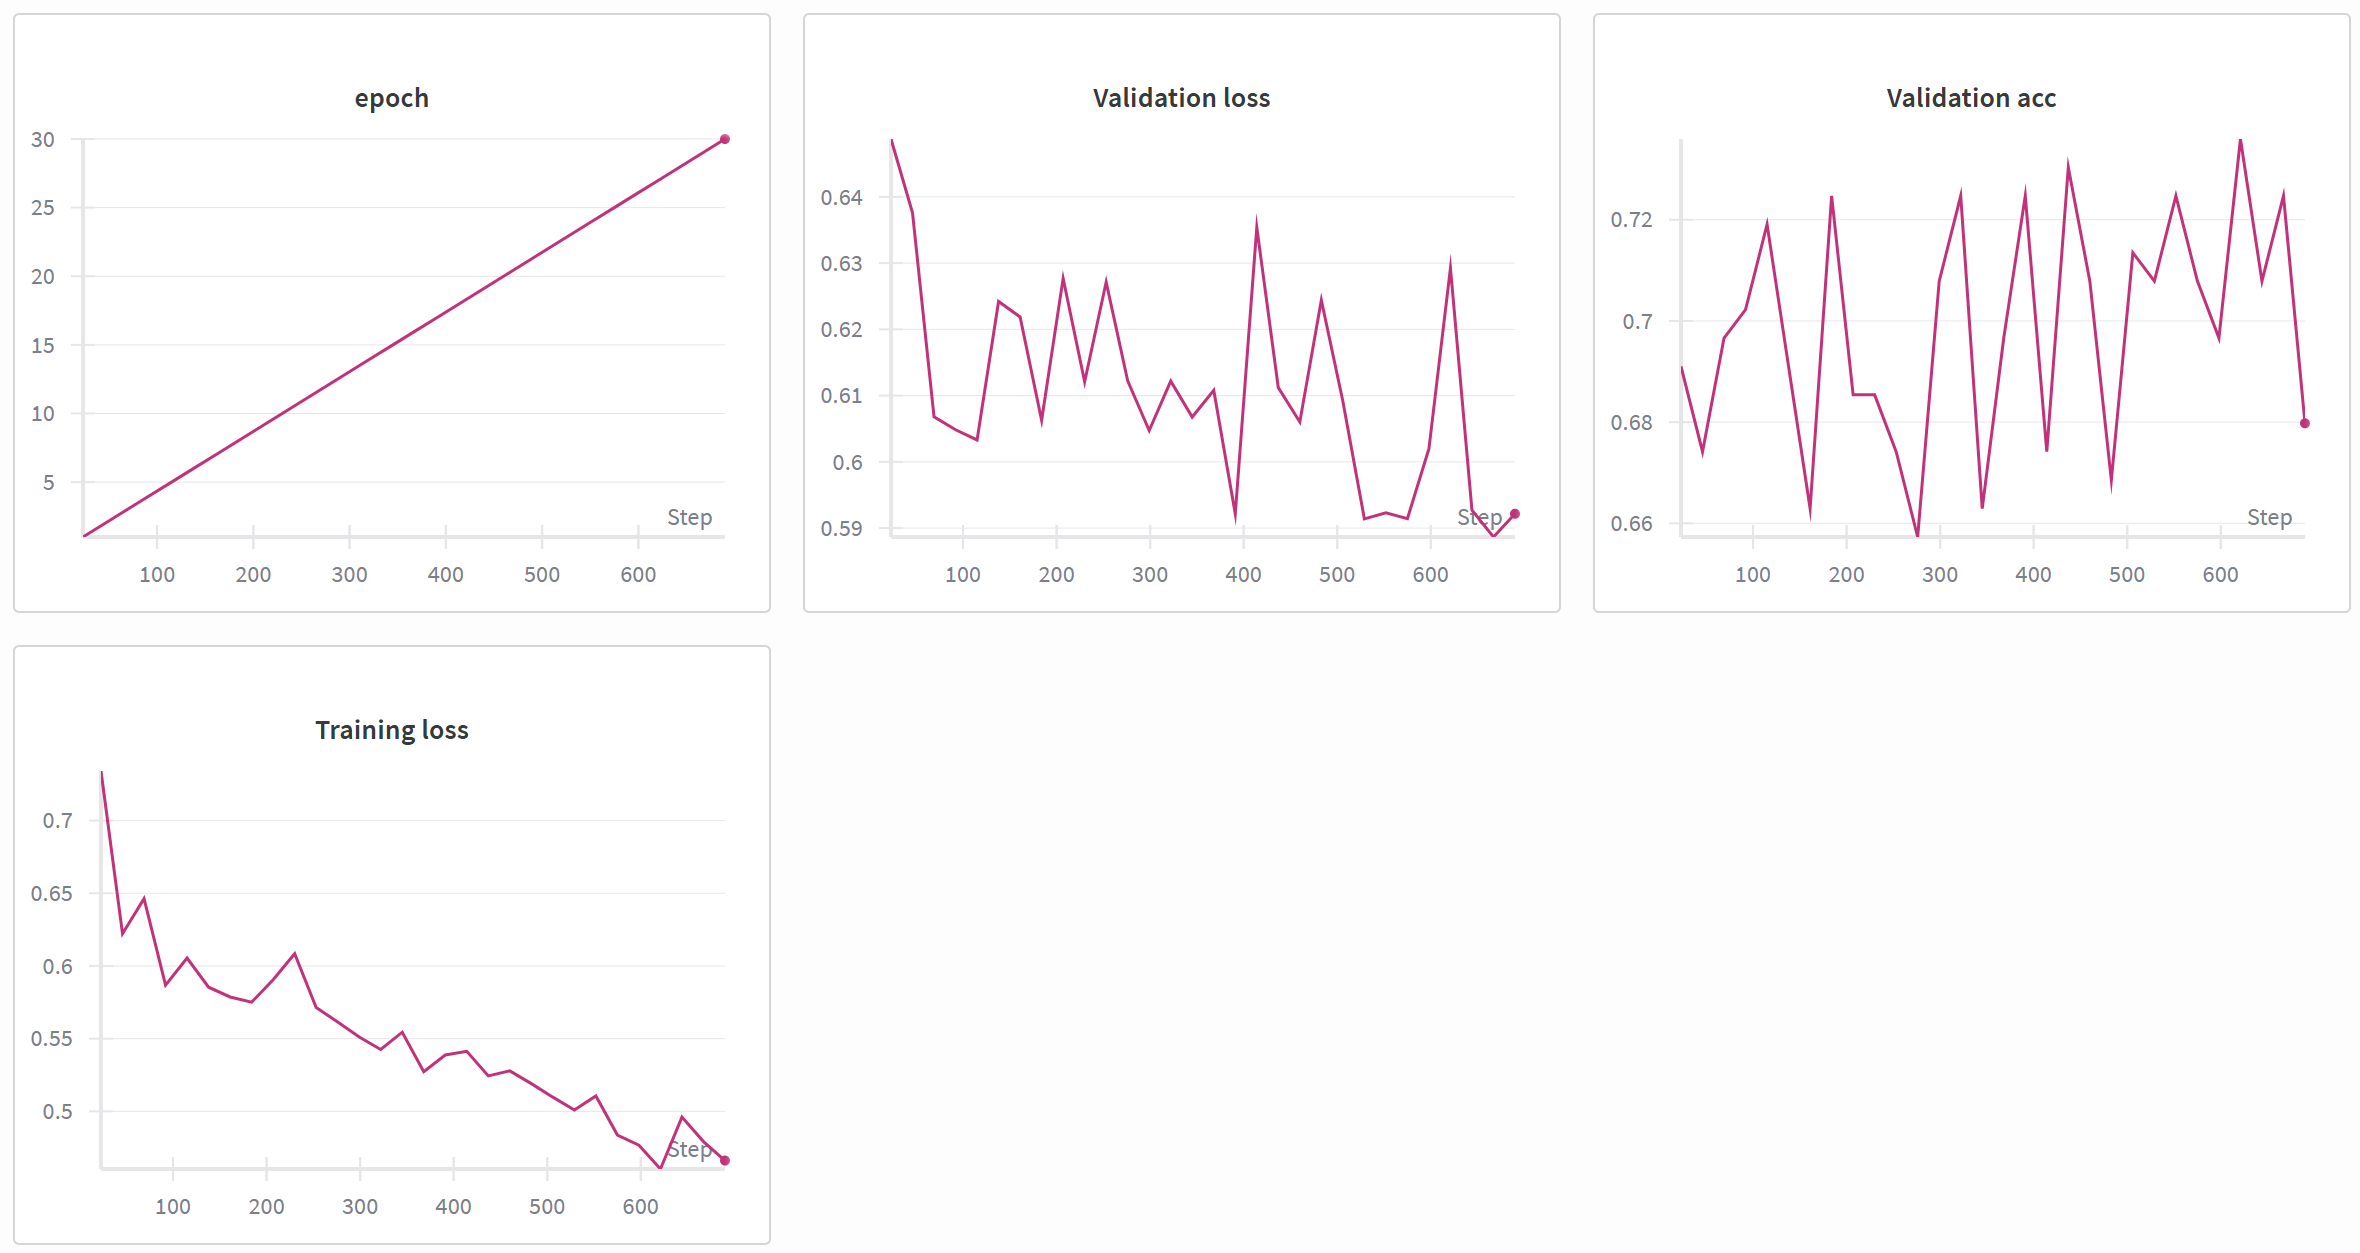
  
https://wandb.ai/jamespk0725-korea-university-of-technology-and-education/hw2-titanic/runs/5bmw0ss6?nw=nwuserjamespk0725  
  Wandb URL 및 그래프 생성 완료

## 요구사항 2

- 일차적으로 배치 크기를 고정해두고 활성화 함수들 중 최고의 결과를 내는 활성화 함수를 찾음.
- 그 후 배치 크기를 변경해가며 최적의 값을 찾는다.

In [8]:
import torch
torch.manual_seed(42)

!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 32 -e 30 --activation relu
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 32  -e 30 --activation sigmoid
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 32  -e 30 --activation elu
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 32 -e 30 --activation leaky_relu

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

## 결과 요약  
  
ReLU → Valid Acc 0.7865, Valid Loss 0.4716  
Sigmoid → 0.8371, 0.4528   
ELU → 0.7697, 0.5338  
Leaky ReLU → 0.7865, 0.4833  
  
Sigmoid가 최적의 결과를 가져왔다.  
이제 활성화 함수는 Sigmoid로 고정하고 배치 크기를 변동시킨다.

In [9]:
import torch
torch.manual_seed(42)

!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 16  -e 30 --activation sigmoid
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 32  -e 30 --activation sigmoid
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 64  -e 30 --activation sigmoid
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb -b 128 -e 30 --activation sigmoid

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

*배치 크기 32*인 경우가 최적의 결과를 세팅함.  
결과 -> Sigmoid / Batch size : 32


## 5. 요구사항 3

- 과제 조건: `Sigmoid`, `ReLU`, `ELU`, `LeakyReLU` × `16, 32, 64, 128`  
- 각 조합을 별도의 W&B run으로 기록합니다.  
- (시간이 부족하면 `activations`/`batch_sizes` 리스트를 줄여서 시도해도 됩니다.)


In [11]:
# 우선 최적 하이퍼파라미터로 학습 실행.(Sigmoid / Batch size : 32)
!python c_my_model_training_with_argparse_wandb_titanic.py --wandb --activation sigmoid -b 32 -e 30

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  family_num  alone
0       0.0       3    1  22.0      1      0   7.2500         2      2           1    0.0
1       1.0       1    0  38.0      1      0  71.2833         0      3           1    0.0
2       1.0       3    0  26.0      0      0   7.9250         2      1           0    1.0
3       1.0       1    0  35.0      1      0  53.1000         2      3           1    0.0
4       0.0       3    1  35.0      0      0   8.0500         2      2           0    1.0
5       0.0       3    1  29.0      0      0   8.4583         1      2           0    1.0
6       0.0       1    1  54.0      0      0  51.8625         2      2           0    1.0
7       0.0       3    1   2.0      3      1  21.0750         2      0           4    0.0
8       1.0       3    0  27.0      0      2  1

C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
C:\Users\PYS\anaconda3\envs\link_dl\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` 

뽑았으면 이제 테스트 데이터 로더를 만든다.

In [12]:
from torch.utils.data import DataLoader
from titanic_dataset import get_preprocessed_dataset

train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=len(test_dataset),  # 전체를 한 번에
    shuffle=False
)

C:\Users\PYS\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\PYS\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0750         2      0   
8       1.0       3    0  27.0      0      2  11.1333         2      3   
9       1.0       2    0  14.0      1      0  30.0708         0      3   

   family_num  alone  
0           1    0.


## 고찰

모델 학습 중 validation loss는 에포크이 진행될수록 일정 시점 이후 상승하는 경향을 보였는데,  
이는 과적합이 시작되었음을 의미하며, 단순히 마지막 epoch의 모델을 사용하는 것보다 validation loss가 가장 낮았던 epoch의 모델 파라미터를 사용하는 것이 퍼포먼스가 더 높았다.
  
따라서 본 과제에서는 학습 루프 내에서 매 epoch마다 validation loss를 모니터링하고,  
최저 Loss을 기록한 시점의 모델 파라미터(그러니까 best_state)를 저장하였다.  
  
최종적으로 test 데이터셋의 예측은 이 best_state로 복원된 모델을 사용하여 수행하였다.  

이는 얼리 스토핑 개념과 유사하며, 불필요한 에포크까지 훈련해 과적합되는 것을 방지한다.

In [ ]:
# c_my_model_training_with_argparse_wandb_titanic.py에서 training_loop() 함수 끝부분

if best_state is not None:
    model.load_state_dict(best_state)
    # best_state에서 복원된 모델을 파일로 저장
    torch.save(model.state_dict(), "best_model.pt")

return model

고찰 후 상기 코드를 추가하였다  
c_my_model_training_with_argparse_wandb_titanic.py 안에서  
training_loop() 함수 끝부분에 해당 코드를 추가하면, 학습 종료 시, validation loss가 최소였던 epoch 모델을 자동으로 best_model.pt로 세이브하게 되는 것.

In [17]:
# 메모리의 모델 그대로 사용
import torch, pandas as pd
from torch.utils.data import DataLoader
from titanic_dataset import get_preprocessed_dataset

# 데이터셋 및 로더
_, valid_ds, test_ds = get_preprocessed_dataset()
test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu" # cpu 대신 테스트로 cuda 이용
model.to(device)         # 먼저 학습된 model 객체를 그대로 사용
model.eval()

# 예측
with torch.no_grad() :
    batch = next(iter(test_loader))
    x = batch["input"].to(device)
    preds = model(x).argmax(dim = 1).cpu().numpy()

# CSV 저장
test_df = pd.read_csv("test.csv")
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": preds})
submission.to_csv("submission.csv", index=False)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0750         2      0   
8       1.0       3    0  27.0      0      2  11.1333         2      3   
9       1.0       2    0  14.0      1      0  30.0708         0      3   

   family_num  alone  
0           1    0.

C:\Users\PYS\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\PYS\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo


## 12. 숙제 후기

제출 결과 Kaggle Leaderboard에서 약 0.377의 정확도를 획득하였다.  
뭔가 싶어 csv 파일을 열어 보니 모델이 모든 데이터를 “생존”으로 예측한 결과로 인한 것.

따라서 과제에서 만들어 낸 본 모델은 특정 클래스(생존)에 과도하게 편향되어 있음을 확인할 수 있다.  
향후 개선을 위해서는 학습률 조정 및 활성화 함수 변경 등이 필요할 것 같다.  

과제를 하면서 느꼈던 점은, 일단 c_my_model_training_with_argparse_wandb_titanic를 변조하는 데 상당한 시간이 걸렸지만 일단 하고 나니 요구사항 2까지는 문제없이 전부 진행할 수 있었다.  

본격적으로 시간이 끌렸던 것은 submission.csv 파트(요구사항 3)였으며, csv는 커녕 테스트 데이터 로드를 하는 과정에서 이유를 알 수 없는 오류가 발생해 하루를 꼬박 잡아먹었다. 이유는 알 수 없지만 재부팅하고 코드를 조금 건들이니 해결되었다.